In [1]:
#!pip install keras
#!pip install pydot
#!pip install graphviz
#!pip install pydotplus


In [27]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras 
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow
import tarfile
import cv2
import h5py
import imageio
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageOps
import pandas as pd
from skimage.util import img_as_ubyte
import csv
from numpy import savez_compressed
from numpy import load
import glob
import zipfile
%matplotlib inline
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation,Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Convolution2D
from keras.layers.core import Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical,plot_model,model_to_dot
import pydot
import graphviz
import pydotplus

In [28]:
# import os
# os.environ["PATH"] += '/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/'

# 0.0 Read Train and Test Data From .npz Files

In [3]:
# read train image infomation from training array, which is stored in train_cropped.npz
# tra_images has shape (33402,64,64,3)
train_data1 = load(os.getcwd()+'/data/train_cropped.npz', allow_pickle=True)
train_images = np.asarray(train_data1['arr_0'])
print(train_images.shape)
# read array infomation from training array, which is stored in train_cropped.npz
# tra_images has shape (33402,6)
label_data1 = load(os.getcwd()+'/data/label/train_label.npz', allow_pickle=True)
train_labels = np.asarray(label_data1['arr_0'])
print(train_labels.shape)

(33402, 64, 64, 3)
(33402, 6)


In [4]:
# read train image infomation from training array, which is stored in train_cropped.npz
# tra_images has shape (13068, 64, 64, 3)
test_data1 = load(os.getcwd()+'/data/test_cropped.npz', allow_pickle=True)
test_images = np.asarray(test_data1['arr_0'])
print(test_images.shape)
# read array infomation from training array, which is stored in train_cropped.npz
# tra_images has shape (13068, 6)
label_data2 = load(os.getcwd()+'/data/label/test_label.npz', allow_pickle=True)
test_labels = np.asarray(label_data2['arr_0'])
print(test_labels.shape)

(13068, 64, 64, 3)
(13068, 6)


In [5]:
# get test and train datasets
x_train = train_images
x_test = test_images

In [6]:
#x_train, x_valid, y_train, y_valid = train_test_split(train_images,train_labels, test_size=0.2, shuffle= True)

In [7]:
# change the shape of array, which is similar to .T
def change_shape(array1):
    label_emp = np.empty((array1.shape[1],array1.shape[0]), dtype='uint8')
    for i in range(array1.shape[0]):
        for j in range(array1.shape[1]):
            label_emp[j,i] = array1[i,j]
    return label_emp

In [8]:
# reshape and test
y_train = change_shape(train_labels)
y_test = change_shape(test_labels)
if y_train.shape[0] == 6:
    print('y_train shape is right')
if y_test.shape[0] == 6:
    print('y_train shape is right')
# print(y_train[0].reshape([-1,1]))
# print(y_train.shape)

y_train shape is right
y_train shape is right


# 0.1 Functions

In [9]:
# get test accurracy
def test_acc(model_name):
    pre = model_name.predict(x_test, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    n_pre = [np.argmax(i, axis = 1) for i in pre]
    n_pre = np.asarray(n_pre).T
    acc_result = np.sum(y_test.T == n_pre, axis = 1)
    return np.sum(acc_result==6)/len(y_test.T)

In [10]:
# read number of digits to one-hot code of shape(,6)
def digit_to_categorical_label(data):
    n = data.shape[0]   
    data_cat = np.empty([n, 6])
    for i in range(n):
        data_cat[i] = to_categorical(data[i], num_classes=6)        
    return data_cat

In [11]:
# read every digits to one-hot code of shape(,11)
def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = np.empty([len(data), n, 11])    
    for i in range(n):
        data_cat[:, i] = to_categorical(data[:, i], num_classes=11)        
    return data_cat


In [12]:
# convert all train and test labels to one-hot code
y_train_num = digit_to_categorical_label(y_train[0])
y_train_digits = digit_to_categorical(y_train[1:])
y_test_num = digit_to_categorical_label(y_test[0])
y_test_digits = digit_to_categorical(y_test[1:])
# 
print(y_train_num.shape)
print(y_train_digits.shape)
print(y_test_num.shape)
print(y_test_digits.shape)

(33402, 6)
(5, 33402, 11)
(13068, 6)
(5, 13068, 11)


In [13]:
# function for get results of model for plotting
def get_array(his_name,i):
    val_loss = np.asarray(his_name.history['val_loss'])
    val_acc1 = np.asarray(his_name.history[f'val_dense_{i}_accuracy'])
    val_acc2 = np.asarray(his_name.history[f'val_dense_{i+1}_accuracy'])
    val_acc3 = np.asarray(his_name.history[f'val_dense_{i+2}_accuracy'])
    val_acc4 = np.asarray(his_name.history[f'val_dense_{i+3}_accuracy'])
    val_acc5 = np.asarray(his_name.history[f'val_dense_{i+4}_accuracy'])
    val_acc6 = np.asarray(his_name.history[f'val_dense_{i+5}_accuracy'])
    val_acc = val_acc1*val_acc2*val_acc3*val_acc4*val_acc5*val_acc6
    train_loss = np.asarray(his_name.history['loss'])
    train_acc1 = np.asarray(his_name.history[f'dense_{i}_accuracy'])
    train_acc2 = np.asarray(his_name.history[f'dense_{i+1}_accuracy'])
    train_acc3 = np.asarray(his_name.history[f'dense_{i+2}_accuracy'])
    train_acc4 = np.asarray(his_name.history[f'dense_{i+3}_accuracy'])
    train_acc5 = np.asarray(his_name.history[f'dense_{i+4}_accuracy'])
    train_acc6 = np.asarray(his_name.history[f'dense_{i+5}_accuracy'])
    train_acc =  train_acc1*train_acc2*train_acc3*train_acc4*train_acc5*train_acc6
    return val_loss,val_acc,train_loss,train_acc

# 1. Model with Different Optimizers

In [15]:
# base model with 8 hidden layers
def build_model():
    identifier = Sequential()
    Input_1 = Input(shape=(64,64,3))
    conv_model = BatchNormalization()(Input_1)
    conv_model = Convolution2D(48, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(54, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(128, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(0.1)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(160, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = Flatten()(conv_model)
    conv_model = Dense(1024,activation = 'relu')(conv_model)
    conv_model = Dense(512,activation = 'relu')(conv_model)

    x1 = Dense(6, activation = 'softmax')(conv_model)
    x2 = Dense(11, activation = 'softmax')(conv_model)
    x3 = Dense(11, activation = 'softmax')(conv_model)
    x4 = Dense(11, activation = 'softmax')(conv_model)
    x5 = Dense(11, activation = 'softmax')(conv_model)
    x6 = Dense(11, activation = 'softmax')(conv_model)

    y = [x1,x2,x3,x4,x5,x6]

    identifier = Model(inputs = Input_1, outputs = y)
    return identifier

## 1.1 SGD-8Layers-0Dropout

In [102]:
# model with different optimizers
# 1.1 with optimizer stochastic gradient descent optimizer
model1_1= build_model()
sgd = optimizers.SGD(lr=0.001, clipnorm=1.)
model1_1.compile(optimizer = sgd, loss = "categorical_crossentropy",metrics = ["accuracy"])
history1_1 = model1_1.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=256, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 47s 2ms/step - loss: 13.3166 - dense_51_loss: 1.5827 - dense_52_loss: 2.5299 - dense_53_loss: 2.4776 - dense_54_loss: 2.2994 - dense_55_loss: 2.1587 - dense_56_loss: 2.2626 - dense_51_accuracy: 0.3603 - dense_52_accuracy: 0.0885 - dense_53_accuracy: 0.0789 - dense_54_accuracy: 0.1232 - dense_55_accuracy: 0.1875 - dense_56_accuracy: 0.0757 - val_loss: 13.1411 - val_dense_51_loss: 1.6722 - val_dense_52_loss: 2.3892 - val_dense_53_loss: 2.4080 - val_dense_54_loss: 2.2389 - val_dense_55_loss: 2.2120 - val_dense_56_loss: 2.2188 - val_dense_51_accuracy: 0.5462 - val_dense_52_accuracy: 0.0913 - val_dense_53_accuracy: 0.0865 - val_dense_54_accuracy: 0.5335 - val_dense_55_accuracy: 0.6515 - val_dense_56_accuracy: 0.0000e+00
Epoch 2/20
26721/26721 [==============================] - 44s 2ms/step - loss: 11.4669 - dense_51_loss: 1.4329 - dense_52_loss: 2.4667 - dense_53_loss: 2.4721 - dense_5

In [103]:
print(model1_1.metrics_names)

['loss', 'dense_51_loss', 'dense_52_loss', 'dense_53_loss', 'dense_54_loss', 'dense_55_loss', 'dense_56_loss', 'dense_51_accuracy', 'dense_52_accuracy', 'dense_53_accuracy', 'dense_54_accuracy', 'dense_55_accuracy', 'dense_56_accuracy']


In [104]:
test1_1 = test_acc(model1_1)
print(test1_1)
val_loss1_1,val_acc1_1,train_loss1_1,train_acc1_1 = get_array(history1_1,51)
val_acc1_1 = np.insert(val_acc1_1,0,0)
train_acc1_1 = np.insert(train_acc1_1,0,0)

0.011401897765534129


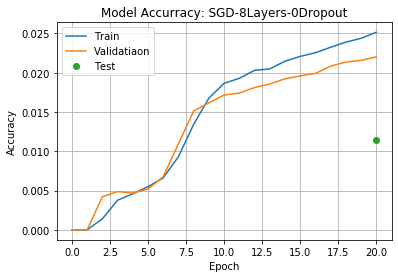

In [105]:
# plt.plot(val_loss1_2)
%matplotlib inline
# plt.plot(plt.plot(val_acc1_2))
plt.plot(train_acc1_1)
plt.plot(val_acc1_1)
plt.plot(20,test1_1,'o')
plt.title('Model Accurracy: SGD-8Layers-0Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validatiaon','Test'], loc='upper left')
plt.grid()
plt.show()

## 1.2 RMSProp-8Layer-0Dropout

In [41]:
# model with different optimizers
# 1.2 with optimizer stochastic RMSprop optimizer
model1_2= build_model()
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model1_2.compile(optimizer = rms, loss = "categorical_crossentropy",metrics = ["accuracy"])
history1_2 = model1_2.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 64s 2ms/step - loss: 6.6567 - dense_27_loss: 0.8667 - dense_28_loss: 2.0470 - dense_29_loss: 2.2786 - dense_30_loss: 1.1816 - dense_31_loss: 0.2643 - dense_32_loss: 0.0166 - dense_27_accuracy: 0.6399 - dense_28_accuracy: 0.2702 - dense_29_accuracy: 0.2083 - dense_30_accuracy: 0.6977 - dense_31_accuracy: 0.9549 - dense_32_accuracy: 0.9973 - val_loss: 5.7719 - val_dense_27_loss: 0.6777 - val_dense_28_loss: 1.8139 - val_dense_29_loss: 2.0633 - val_dense_30_loss: 0.9477 - val_dense_31_loss: 0.2649 - val_dense_32_loss: 0.0038 - val_dense_27_accuracy: 0.7520 - val_dense_28_accuracy: 0.3312 - val_dense_29_accuracy: 0.3040 - val_dense_30_accuracy: 0.7165 - val_dense_31_accuracy: 0.9542 - val_dense_32_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 60s 2ms/step - loss: 3.8918 - dense_27_loss: 0.3780 - dense_28_loss: 1.1488 - dense_29_loss: 1.4070 - dense_30_loss:

In [77]:
test1_2 = test_acc(model1_2)
print(test1_2)

0.8193296602387512


In [90]:
val_loss1_2,val_acc1_2,train_loss1_2,train_acc1_2 = get_array(history1_2,27)
val_acc1_2 = np.insert(val_acc1_2,0,0)
train_acc1_2 = np.insert(train_acc1_2,0,0)

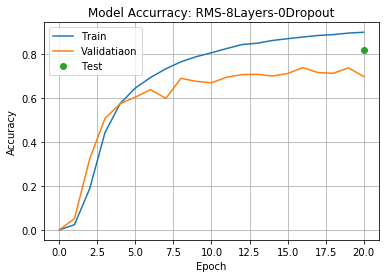

In [98]:
# plt.plot(val_loss1_2)
%matplotlib inline
# plt.plot(plt.plot(val_acc1_2))
plt.plot(train_acc1_2)
plt.plot(val_acc1_2)
plt.plot(20,test1_2,'o')
plt.title('Model Accurracy: RMS-8Layers-0Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend([ 'Train','Validatiaon','Test'], loc='upper left')
plt.grid()
plt.show()

## 1.3 Nadam-8Layer-0Dropout

In [43]:
# model with different optimizers
# 1.3 with optimizer stochastic Nadam
model1_3= build_model()
nadam = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model1_3.compile(optimizer = nadam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history1_3 = model1_3.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 70s 3ms/step - loss: 5.0155 - dense_35_loss: 0.6018 - dense_36_loss: 1.4907 - dense_37_loss: 1.7523 - dense_38_loss: 0.9522 - dense_39_loss: 0.2054 - dense_40_loss: 0.0111 - dense_35_accuracy: 0.7523 - dense_36_accuracy: 0.4813 - dense_37_accuracy: 0.3965 - dense_38_accuracy: 0.7267 - dense_39_accuracy: 0.9554 - dense_40_accuracy: 0.9977 - val_loss: 3.1146 - val_dense_35_loss: 0.3098 - val_dense_36_loss: 0.9154 - val_dense_37_loss: 1.1197 - val_dense_38_loss: 0.6098 - val_dense_39_loss: 0.1566 - val_dense_40_loss: 0.0029 - val_dense_35_accuracy: 0.8877 - val_dense_36_accuracy: 0.7170 - val_dense_37_accuracy: 0.6402 - val_dense_38_accuracy: 0.8086 - val_dense_39_accuracy: 0.9591 - val_dense_40_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 67s 2ms/step - loss: 2.0224 - dense_35_loss: 0.2075 - dense_36_loss: 0.5324 - dense_37_loss: 0.6988 - dense_38_loss:

In [79]:
print(model1_3.metrics_names)

['loss', 'dense_35_loss', 'dense_36_loss', 'dense_37_loss', 'dense_38_loss', 'dense_39_loss', 'dense_40_loss', 'dense_35_accuracy', 'dense_36_accuracy', 'dense_37_accuracy', 'dense_38_accuracy', 'dense_39_accuracy', 'dense_40_accuracy']


In [95]:
test1_3 = test_acc(model1_3)
print(test1_3)
val_loss1_3,val_acc1_3,train_loss1_3,train_acc1_3 = get_array(history1_3,35)
val_acc1_3 = np.insert(val_acc1_3,0,0)
train_acc1_3 = np.insert(train_acc1_3,0,0)

0.8561371288644016


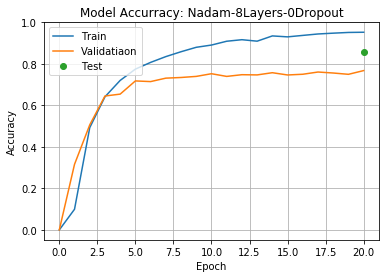

In [97]:
# plt.plot(val_loss1_2)
%matplotlib inline
# plt.plot(plt.plot(val_acc1_2))
plt.plot(train_acc1_3)
plt.plot(val_acc1_3)
plt.plot(20,test1_3,'o')
plt.title('Model Accurracy: Nadam-8Layers-0Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validatiaon','Test'], loc='upper left')
plt.grid()
plt.show()

## 1.4 Adam-8Layer-0Dropout

In [45]:
# model with different optimizers
# 1.4 with optimizer stochastic Adam optimizer
model1_4= build_model()
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model1_4.compile(optimizer = adam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history1_4 = model1_4.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 65s 2ms/step - loss: 5.4119 - dense_43_loss: 0.5896 - dense_44_loss: 1.6706 - dense_45_loss: 1.9486 - dense_46_loss: 0.9938 - dense_47_loss: 0.1983 - dense_48_loss: 0.0083 - dense_43_accuracy: 0.7586 - dense_44_accuracy: 0.4116 - dense_45_accuracy: 0.3190 - dense_46_accuracy: 0.7103 - dense_47_accuracy: 0.9551 - dense_48_accuracy: 0.9996 - val_loss: 3.8922 - val_dense_43_loss: 0.3689 - val_dense_44_loss: 1.0852 - val_dense_45_loss: 1.3939 - val_dense_46_loss: 0.8370 - val_dense_47_loss: 0.2013 - val_dense_48_loss: 0.0028 - val_dense_43_accuracy: 0.8716 - val_dense_44_accuracy: 0.6322 - val_dense_45_accuracy: 0.5323 - val_dense_46_accuracy: 0.7273 - val_dense_47_accuracy: 0.9552 - val_dense_48_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 62s 2ms/step - loss: 2.5453 - dense_43_loss: 0.2427 - dense_44_loss: 0.6766 - dense_45_loss: 0.9089 - dense_46_loss:

In [81]:
print(model1_4.metrics_names)

['loss', 'dense_43_loss', 'dense_44_loss', 'dense_45_loss', 'dense_46_loss', 'dense_47_loss', 'dense_48_loss', 'dense_43_accuracy', 'dense_44_accuracy', 'dense_45_accuracy', 'dense_46_accuracy', 'dense_47_accuracy', 'dense_48_accuracy']


In [100]:
test1_4 = test_acc(model1_4)
print(test1_4)
val_loss1_4,val_acc1_4,train_loss1_4,train_acc1_4 = get_array(history1_4,43)
val_acc1_4 = np.insert(val_acc1_4,0,0)
train_acc1_4 = np.insert(train_acc1_4,0,0)

0.8339455157636976


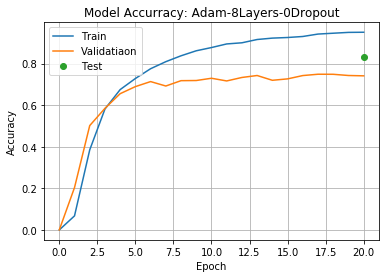

In [101]:
# plt.plot(val_loss1_2)
%matplotlib inline
# plt.plot(plt.plot(val_acc1_2))
plt.plot(train_acc1_4)
plt.plot(val_acc1_4)
plt.plot(20,test1_4,'o')
plt.title('Model Accurracy: Adam-8Layers-0Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validatiaon','Test'], loc='upper left')
plt.grid()
plt.show()

# 2. Model with different Dropout Rates

In [106]:
def build_model2(rate):
    identifier = Sequential()
    Input_1 = Input(shape=(64,64,3))
    conv_model = BatchNormalization()(Input_1)
    conv_model = Convolution2D(48, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(54, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(128, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(0.1)(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(160, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = Flatten()(conv_model)
    conv_model = Dense(1024,activation = 'relu')(conv_model)
    conv_model = Dense(512,activation = 'relu')(conv_model)

    x1 = Dense(6, activation = 'softmax')(conv_model)
    x2 = Dense(11, activation = 'softmax')(conv_model)
    x3 = Dense(11, activation = 'softmax')(conv_model)
    x4 = Dense(11, activation = 'softmax')(conv_model)
    x5 = Dense(11, activation = 'softmax')(conv_model)
    x6 = Dense(11, activation = 'softmax')(conv_model)

    y = [x1,x2,x3,x4,x5,x6]

    identifier = Model(inputs = Input_1, outputs = y)
    return identifier

## 2.1 Nadam-8Layer-0.3Dropout

In [107]:
model2_1= build_model2(0.3)
nadam = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model2_1.compile(optimizer = nadam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history2_1 = model2_1.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 76s 3ms/step - loss: 6.0082 - dense_59_loss: 0.7440 - dense_60_loss: 1.8362 - dense_61_loss: 2.1150 - dense_62_loss: 1.0802 - dense_63_loss: 0.2202 - dense_64_loss: 0.0109 - dense_59_accuracy: 0.6874 - dense_60_accuracy: 0.3453 - dense_61_accuracy: 0.2623 - dense_62_accuracy: 0.7057 - dense_63_accuracy: 0.9548 - dense_64_accuracy: 0.9974 - val_loss: 4.4463 - val_dense_59_loss: 0.4704 - val_dense_60_loss: 1.3300 - val_dense_61_loss: 1.5851 - val_dense_62_loss: 0.8644 - val_dense_63_loss: 0.2001 - val_dense_64_loss: 0.0029 - val_dense_59_accuracy: 0.8277 - val_dense_60_accuracy: 0.5664 - val_dense_61_accuracy: 0.4784 - val_dense_62_accuracy: 0.7334 - val_dense_63_accuracy: 0.9542 - val_dense_64_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 71s 3ms/step - loss: 3.0954 - dense_59_loss: 0.3080 - dense_60_loss: 0.8599 - dense_61_loss: 1.0955 - dense_62_loss:

In [109]:
print(model2_1.metrics_names)

['loss', 'dense_59_loss', 'dense_60_loss', 'dense_61_loss', 'dense_62_loss', 'dense_63_loss', 'dense_64_loss', 'dense_59_accuracy', 'dense_60_accuracy', 'dense_61_accuracy', 'dense_62_accuracy', 'dense_63_accuracy', 'dense_64_accuracy']


In [29]:
test2_1 = test_acc(model2_1)
print(test2_1)
val_loss2_1,val_acc2_1,train_loss2_1,train_acc2_1 = get_array(history2_1,59)
val_acc2_1 = np.insert(val_acc2_1,0,0)
train_acc2_1 = np.insert(train_acc2_1,0,0)

0.8297826752372206


## 2.2 Nadam-8Layer-0.5Dropout

In [108]:
model2_2= build_model2(0.5)
nadam = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model2_2.compile(optimizer = nadam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history2_2 = model2_2.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 75s 3ms/step - loss: 6.5021 - dense_67_loss: 0.8321 - dense_68_loss: 2.0229 - dense_69_loss: 2.2677 - dense_70_loss: 1.1403 - dense_71_loss: 0.2291 - dense_72_loss: 0.0092 - dense_67_accuracy: 0.6422 - dense_68_accuracy: 0.2730 - dense_69_accuracy: 0.2080 - dense_70_accuracy: 0.6988 - dense_71_accuracy: 0.9553 - dense_72_accuracy: 0.9988 - val_loss: 5.7312 - val_dense_67_loss: 0.6007 - val_dense_68_loss: 1.8396 - val_dense_69_loss: 2.1058 - val_dense_70_loss: 0.9867 - val_dense_71_loss: 0.1923 - val_dense_72_loss: 0.0029 - val_dense_67_accuracy: 0.7472 - val_dense_68_accuracy: 0.3411 - val_dense_69_accuracy: 0.2693 - val_dense_70_accuracy: 0.7120 - val_dense_71_accuracy: 0.9542 - val_dense_72_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 70s 3ms/step - loss: 4.8805 - dense_67_loss: 0.4716 - dense_68_loss: 1.5307 - dense_69_loss: 1.7819 - dense_70_loss:

In [112]:
print(model2_2.metrics_names)

['loss', 'dense_67_loss', 'dense_68_loss', 'dense_69_loss', 'dense_70_loss', 'dense_71_loss', 'dense_72_loss', 'dense_67_accuracy', 'dense_68_accuracy', 'dense_69_accuracy', 'dense_70_accuracy', 'dense_71_accuracy', 'dense_72_accuracy']


In [30]:
test2_2 = test_acc(model2_2)
print(test2_2)
val_loss2_2,val_acc2_2,train_loss2_2,train_acc2_2 = get_array(history2_2,67)
val_acc2_2 = np.insert(val_acc2_2,0,0)
train_acc2_2 = np.insert(train_acc2_2,0,0)

0.7260330578512396


# 3. Model with different hidden layers


## 3.1 Adam-2Layer-0Dropout

In [119]:
# 3.1 model with 2 hidden layers
def build_model3():
    identifier = Sequential()
    Input_1 = Input(shape=(64,64,3))
    conv_model = BatchNormalization()(Input_1)
    conv_model = Convolution2D(48, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(128, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = Flatten()(conv_model)
    conv_model = Dense(1024,activation = 'relu')(conv_model)
    conv_model = Dense(512,activation = 'relu')(conv_model)

    x1 = Dense(6, activation = 'softmax')(conv_model)
    x2 = Dense(11, activation = 'softmax')(conv_model)
    x3 = Dense(11, activation = 'softmax')(conv_model)
    x4 = Dense(11, activation = 'softmax')(conv_model)
    x5 = Dense(11, activation = 'softmax')(conv_model)
    x6 = Dense(11, activation = 'softmax')(conv_model)
    
    y = [x1,x2,x3,x4,x5,x6]
    identifier = Model(inputs = Input_1, outputs = y)
    return identifier

In [121]:
model3_1= build_model3()
#adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
nadam = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model3_1.compile(optimizer = nadam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history3_1 = model3_1.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 95s 4ms/step - loss: 40.4872 - dense_91_loss: 7.3854 - dense_92_loss: 13.0339 - dense_93_loss: 14.4824 - dense_94_loss: 4.8875 - dense_95_loss: 0.6920 - dense_96_loss: 0.0106 - dense_91_accuracy: 0.5402 - dense_92_accuracy: 0.1895 - dense_93_accuracy: 0.0996 - dense_94_accuracy: 0.6950 - dense_95_accuracy: 0.9551 - dense_96_accuracy: 0.9975 - val_loss: 40.4967 - val_dense_91_loss: 7.2591 - val_dense_92_loss: 13.0858 - val_dense_93_loss: 14.4988 - val_dense_94_loss: 4.8888 - val_dense_95_loss: 0.7339 - val_dense_96_loss: 0.0048 - val_dense_91_accuracy: 0.5489 - val_dense_92_accuracy: 0.1883 - val_dense_93_accuracy: 0.1006 - val_dense_94_accuracy: 0.6959 - val_dense_95_accuracy: 0.9542 - val_dense_96_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 92s 3ms/step - loss: 40.5507 - dense_91_loss: 7.3939 - dense_92_loss: 13.0637 - dense_93_loss: 14.5143 - dense

In [122]:
print(model3_1.metrics_names)

['loss', 'dense_91_loss', 'dense_92_loss', 'dense_93_loss', 'dense_94_loss', 'dense_95_loss', 'dense_96_loss', 'dense_91_accuracy', 'dense_92_accuracy', 'dense_93_accuracy', 'dense_94_accuracy', 'dense_95_accuracy', 'dense_96_accuracy']


In [123]:
test3_1 = test_acc(model3_1)
print(test3_1)
val_loss3_1,val_acc3_1,train_loss3_1,train_acc3_1 = get_array(history3_1,91)
val_acc3_1 = np.insert(val_acc3_1,0,0)
train_acc3_1 = np.insert(train_acc3_1,0,0)

0.016911539638812367


## 3.2 Adam-4Layer-0Dropout

In [143]:
# 3.2 model with 4 hidden layers
def build_model3_2():
    identifier = Sequential()
    Input_1 = Input(shape=(64,64,3))
    conv_model = BatchNormalization()(Input_1)
    conv_model = Convolution2D(48, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(54, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    
    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(128, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(0.1)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(160, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = Flatten()(conv_model)
    conv_model = Dense(1024,activation = 'relu')(conv_model)
    conv_model = Dense(512,activation = 'relu')(conv_model)

    x1 = Dense(6, activation = 'softmax')(conv_model)
    x2 = Dense(11, activation = 'softmax')(conv_model)
    x3 = Dense(11, activation = 'softmax')(conv_model)
    x4 = Dense(11, activation = 'softmax')(conv_model)
    x5 = Dense(11, activation = 'softmax')(conv_model)
    x6 = Dense(11, activation = 'softmax')(conv_model)
    
    y = [x1,x2,x3,x4,x5,x6]
    identifier = Model(inputs = Input_1, outputs = y)
    return identifier

In [137]:
model3_2= build_model3_2()
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model3_2.compile(optimizer = adam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history3_2 = model3_2.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 68s 3ms/step - loss: 40.9942 - dense_99_loss: 7.3799 - dense_100_loss: 13.0407 - dense_101_loss: 14.9841 - dense_102_loss: 4.8840 - dense_103_loss: 0.6891 - dense_104_loss: 0.0132 - dense_99_accuracy: 0.5404 - dense_100_accuracy: 0.1892 - dense_101_accuracy: 0.0684 - dense_102_accuracy: 0.6950 - dense_103_accuracy: 0.9552 - dense_104_accuracy: 0.9973 - val_loss: 41.0347 - val_dense_99_loss: 7.2591 - val_dense_100_loss: 13.0858 - val_dense_101_loss: 15.0337 - val_dense_102_loss: 4.8888 - val_dense_103_loss: 0.7339 - val_dense_104_loss: 0.0048 - val_dense_99_accuracy: 0.5489 - val_dense_100_accuracy: 0.1883 - val_dense_101_accuracy: 0.0672 - val_dense_102_accuracy: 0.6959 - val_dense_103_accuracy: 0.9542 - val_dense_104_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 64s 2ms/step - loss: 41.0501 - dense_99_loss: 7.3939 - dense_100_loss: 13.0648 - dense_101

In [138]:
print(model3_2.metrics_names)

['loss', 'dense_99_loss', 'dense_100_loss', 'dense_101_loss', 'dense_102_loss', 'dense_103_loss', 'dense_104_loss', 'dense_99_accuracy', 'dense_100_accuracy', 'dense_101_accuracy', 'dense_102_accuracy', 'dense_103_accuracy', 'dense_104_accuracy']


In [140]:
test3_2 = test_acc(model3_2)
print(test3_2)
val_loss3_2,val_acc3_2,train_loss3_2,train_acc3_2 = get_array(history3_2,99)
val_acc3_2 = np.insert(val_acc3_2,0,0)
train_acc3_2 = np.insert(train_acc3_2,0,0)

0.011095806550352005


## 3.3 Adam-6Layer-0Dropout

In [147]:
# 3.3 model with 6 hidden layers
def build_model3_3():
    identifier = Sequential()
    Input_1 = Input(shape=(64,64,3))
    conv_model = BatchNormalization()(Input_1)
    conv_model = Convolution2D(48, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(54, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(128, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(0.1)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(160, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = Flatten()(conv_model)
    conv_model = Dense(1024,activation = 'relu')(conv_model)
    conv_model = Dense(512,activation = 'relu')(conv_model)

    x1 = Dense(6, activation = 'softmax')(conv_model)
    x2 = Dense(11, activation = 'softmax')(conv_model)
    x3 = Dense(11, activation = 'softmax')(conv_model)
    x4 = Dense(11, activation = 'softmax')(conv_model)
    x5 = Dense(11, activation = 'softmax')(conv_model)
    x6 = Dense(11, activation = 'softmax')(conv_model)
    
    y = [x1,x2,x3,x4,x5,x6]
    identifier = Model(inputs = Input_1, outputs = y)
    return identifier

In [148]:
model3_3= build_model3_3()
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model3_3.compile(optimizer = adam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history3_3 = model3_3.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 62s 2ms/step - loss: 11.1512 - dense_107_loss: 1.9398 - dense_108_loss: 3.3330 - dense_109_loss: 3.7579 - dense_110_loss: 1.7797 - dense_111_loss: 0.3268 - dense_112_loss: 0.0144 - dense_107_accuracy: 0.5357 - dense_108_accuracy: 0.2528 - dense_109_accuracy: 0.1434 - dense_110_accuracy: 0.6945 - dense_111_accuracy: 0.9550 - dense_112_accuracy: 0.9979 - val_loss: 26.4582 - val_dense_107_loss: 4.8543 - val_dense_108_loss: 7.7227 - val_dense_109_loss: 9.4735 - val_dense_110_loss: 3.6875 - val_dense_111_loss: 0.6913 - val_dense_112_loss: 0.0050 - val_dense_107_accuracy: 0.5460 - val_dense_108_accuracy: 0.2658 - val_dense_109_accuracy: 0.1176 - val_dense_110_accuracy: 0.6959 - val_dense_111_accuracy: 0.9542 - val_dense_112_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 57s 2ms/step - loss: 8.8871 - dense_107_loss: 1.4832 - dense_108_loss: 2.4882 - dense_109_

In [166]:
print(model3_3.metrics_names)

['loss', 'dense_107_loss', 'dense_108_loss', 'dense_109_loss', 'dense_110_loss', 'dense_111_loss', 'dense_112_loss', 'dense_107_accuracy', 'dense_108_accuracy', 'dense_109_accuracy', 'dense_110_accuracy', 'dense_111_accuracy', 'dense_112_accuracy']


In [167]:
test3_3 = test_acc(model3_3)
print(test3_3)
val_loss3_3,val_acc3_3,train_loss3_3,train_acc3_3 = get_array(history3_3,107)
val_acc3_3 = np.insert(val_acc3_3,0,0)
train_acc3_3 = np.insert(train_acc3_3,0,0)

0.7639271502907866


## 3.4 Adam-10Layer-0Dropout

In [157]:
# 3.4 model with 10 hidden layers 
def build_model3_4():
    identifier = Sequential()
    Input_1 = Input(shape=(64,64,3))
    conv_model = BatchNormalization()(Input_1)
    conv_model = Convolution2D(48, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(54, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(128, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(0.1)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(160, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(160, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    
    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    
    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)

    conv_model = Flatten()(conv_model)
    conv_model = Dense(1024,activation = 'relu')(conv_model)
    conv_model = Dense(512,activation = 'relu')(conv_model)

    x1 = Dense(6, activation = 'softmax')(conv_model)
    x2 = Dense(11, activation = 'softmax')(conv_model)
    x3 = Dense(11, activation = 'softmax')(conv_model)
    x4 = Dense(11, activation = 'softmax')(conv_model)
    x5 = Dense(11, activation = 'softmax')(conv_model)
    x6 = Dense(11, activation = 'softmax')(conv_model)

    y = [x1,x2,x3,x4,x5,x6]

    identifier = Model(inputs = Input_1, outputs = y)
    return identifier

In [158]:
model3_4= build_model3_4()
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model3_4.compile(optimizer = adam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history3_4 = model3_4.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 84s 3ms/step - loss: 5.6903 - dense_115_loss: 0.6858 - dense_116_loss: 1.7281 - dense_117_loss: 2.0078 - dense_118_loss: 1.0460 - dense_119_loss: 0.2122 - dense_120_loss: 0.0090 - dense_115_accuracy: 0.7133 - dense_116_accuracy: 0.3905 - dense_117_accuracy: 0.3034 - dense_118_accuracy: 0.7060 - dense_119_accuracy: 0.9563 - dense_120_accuracy: 0.9985 - val_loss: 4.9750 - val_dense_115_loss: 0.5535 - val_dense_116_loss: 1.5406 - val_dense_117_loss: 1.6300 - val_dense_118_loss: 1.0086 - val_dense_119_loss: 0.2384 - val_dense_120_loss: 0.0023 - val_dense_115_accuracy: 0.8042 - val_dense_116_accuracy: 0.5465 - val_dense_117_accuracy: 0.4887 - val_dense_118_accuracy: 0.7216 - val_dense_119_accuracy: 0.9542 - val_dense_120_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 77s 3ms/step - loss: 2.8282 - dense_115_loss: 0.2817 - dense_116_loss: 0.7634 - dense_117_lo

In [159]:
print(model3_4.metrics_names)

['loss', 'dense_115_loss', 'dense_116_loss', 'dense_117_loss', 'dense_118_loss', 'dense_119_loss', 'dense_120_loss', 'dense_115_accuracy', 'dense_116_accuracy', 'dense_117_accuracy', 'dense_118_accuracy', 'dense_119_accuracy', 'dense_120_accuracy']


In [161]:
test3_4 = test_acc(model3_4)
print(test3_4)
val_loss3_4,val_acc3_4,train_loss3_4,train_acc3_4 = get_array(history3_4,115)
val_acc3_4 = np.insert(val_acc3_4,0,0)
train_acc3_4 = np.insert(train_acc3_4,0,0)

0.8494031221303948


# 4. Model with Different Learning Rates

## 4.1 with 0.005 learning rate

In [16]:
# model with different optimizers
# 4.1 with 0.005 learning rate
model4_1= build_model()
adam = optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model4_1.compile(optimizer = adam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history4_1 = model4_1.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=256, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 51s 2ms/step - loss: 10.7070 - dense_3_loss: 1.9079 - dense_4_loss: 3.0610 - dense_5_loss: 3.4987 - dense_6_loss: 1.7639 - dense_7_loss: 0.4059 - dense_8_loss: 0.0515 - dense_3_accuracy: 0.5184 - dense_4_accuracy: 0.2577 - dense_5_accuracy: 0.1403 - dense_6_accuracy: 0.6894 - dense_7_accuracy: 0.9486 - dense_8_accuracy: 0.9903 - val_loss: 22.0385 - val_dense_3_loss: 3.7434 - val_dense_4_loss: 6.7903 - val_dense_5_loss: 7.7021 - val_dense_6_loss: 2.8797 - val_dense_7_loss: 0.7061 - val_dense_8_loss: 0.0266 - val_dense_3_accuracy: 0.5284 - val_dense_4_accuracy: 0.2317 - val_dense_5_accuracy: 0.1163 - val_dense_6_accuracy: 0.6959 - val_dense_7_accuracy: 0.9542 - val_dense_8_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 44s 2ms/step - los

26721/26721 [==============================] - 44s 2ms/step - loss: 5.6182 - dense_3_loss: 0.4606 - dense_4_loss: 1.9706 - dense_5_loss: 2.0704 - dense_6_loss: 0.9368 - dense_7_loss: 0.1773 - dense_8_loss: 0.0029 - dense_3_accuracy: 0.8198 - dense_4_accuracy: 0.2739 - dense_5_accuracy: 0.2576 - dense_6_accuracy: 0.7138 - dense_7_accuracy: 0.9575 - dense_8_accuracy: 0.9997 - val_loss: 5.8709 - val_dense_3_loss: 0.5720 - val_dense_4_loss: 1.9882 - val_dense_5_loss: 2.1227 - val_dense_6_loss: 1.0067 - val_dense_7_loss: 0.1795 - val_dense_8_loss: 0.0037 - val_dense_3_accuracy: 0.7632 - val_dense_4_accuracy: 0.2703 - val_dense_5_accuracy: 0.2425 - val_dense_6_accuracy: 0.7054 - val_dense_7_accuracy: 0.9542 - val_dense_8_accuracy: 0.9997
Epoch 12/20
26721/26721 [==============================] - 44s 2ms/step - loss: 5.4515 - dense_3_loss: 0.4027 - dense_4_loss: 1.9597 - dense_5_loss: 2.0139 - dense_6_loss: 0.9060 - dense_7_loss: 0.1652 - dense_8_loss: 0.0031 - dense_3_accuracy: 0.8450 - dens

In [18]:
print(model4_1.metrics_names)

['loss', 'dense_3_loss', 'dense_4_loss', 'dense_5_loss', 'dense_6_loss', 'dense_7_loss', 'dense_8_loss', 'dense_3_accuracy', 'dense_4_accuracy', 'dense_5_accuracy', 'dense_6_accuracy', 'dense_7_accuracy', 'dense_8_accuracy']


In [19]:
test4_1 = test_acc(model4_1)
print(test4_1)
val_loss4_1,val_acc4_1,train_loss4_1,train_acc4_1 = get_array(history4_1,3)
val_acc4_1 = np.insert(val_acc4_1,0,0)
train_acc4_1 = np.insert(train_acc4_1,0,0)

0.09496479951025405


## 4.2 with 0.002 learning rate

In [21]:
# model with different optimizers
# 4.2 with 0.002 learning rate
model4_2= build_model()
adam = optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, amsgrad=False)
model4_2.compile(optimizer = adam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history4_2 = model4_2.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=256, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Train on 26721 samples, validate on 6681 samples
Epoch 1/20
26721/26721 [==============================] - 47s 2ms/step - loss: 6.8621 - dense_19_loss: 0.9115 - dense_20_loss: 2.1005 - dense_21_loss: 2.3596 - dense_22_loss: 1.2075 - dense_23_loss: 0.2437 - dense_24_loss: 0.0331 - dense_19_accuracy: 0.6140 - dense_20_accuracy: 0.2598 - dense_21_accuracy: 0.1901 - dense_22_accuracy: 0.6900 - dense_23_accuracy: 0.9506 - dense_24_accuracy: 0.9901 - val_loss: 10.3638 - val_dense_19_loss: 2.2012 - val_dense_20_loss: 2.5158 - val_dense_21_loss: 3.3502 - val_dense_22_loss: 1.8929 - val_dense_23_loss: 0.3743 - val_dense_24_loss: 0.0082 - val_dense_19_accuracy: 0.3455 - val_dense_20_accuracy: 0.2678 - val_dense_21_accuracy: 0.1869 - val_dense_22_accuracy: 0.6789 - val_dense_23_accuracy: 0.9542 - val_dense_24_accuracy: 0.9997
Epoch 2/20
26721/26721 [==============================] - 45s 2ms/step - loss: 5.5599 - dense_19_loss: 0.5313 - dense_20_loss: 1.8480 - dense_21_loss: 2.0265 - dense_22_loss

26721/26721 [==============================] - 45s 2ms/step - loss: 0.5029 - dense_19_loss: 0.0413 - dense_20_loss: 0.1247 - dense_21_loss: 0.1644 - dense_22_loss: 0.1173 - dense_23_loss: 0.0530 - dense_24_loss: 0.0018 - dense_19_accuracy: 0.9857 - dense_20_accuracy: 0.9602 - dense_21_accuracy: 0.9458 - dense_22_accuracy: 0.9620 - dense_23_accuracy: 0.9827 - dense_24_accuracy: 0.9997 - val_loss: 1.3784 - val_dense_19_loss: 0.1609 - val_dense_20_loss: 0.3753 - val_dense_21_loss: 0.4566 - val_dense_22_loss: 0.2979 - val_dense_23_loss: 0.0983 - val_dense_24_loss: 0.0045 - val_dense_19_accuracy: 0.9599 - val_dense_20_accuracy: 0.9124 - val_dense_21_accuracy: 0.8912 - val_dense_22_accuracy: 0.9289 - val_dense_23_accuracy: 0.9756 - val_dense_24_accuracy: 0.9997
Epoch 12/20
26721/26721 [==============================] - 45s 2ms/step - loss: 0.4492 - dense_19_loss: 0.0361 - dense_20_loss: 0.1141 - dense_21_loss: 0.1480 - dense_22_loss: 0.1004 - dense_23_loss: 0.0497 - dense_24_loss: 0.0014 - d

In [23]:
print(model4_2.metrics_names)

['loss', 'dense_19_loss', 'dense_20_loss', 'dense_21_loss', 'dense_22_loss', 'dense_23_loss', 'dense_24_loss', 'dense_19_accuracy', 'dense_20_accuracy', 'dense_21_accuracy', 'dense_22_accuracy', 'dense_23_accuracy', 'dense_24_accuracy']


In [25]:
test4_2 = test_acc(model4_2)
print(test4_2)
val_loss4_2,val_acc4_2,train_loss4_2,train_acc4_2 = get_array(history4_2,19)
val_acc4_2 = np.insert(val_acc4_2,0,0)
train_acc4_2 = np.insert(train_acc4_2,0,0)

0.831114172023263


# 5. Save Training Results to Pickle for Further Usage

In [22]:
model_info = dict()
model_info['val_acc1_1'] = val_acc1_1
model_info['train_acc1_1'] = train_acc1_1
model_info['val_acc1_2'] = val_acc1_2
model_info['train_acc1_2'] = train_acc1_2
model_info['val_acc1_3'] = val_acc1_3
model_info['train_acc1_3'] = train_acc1_3
model_info['val_acc1_4'] = val_acc1_4
model_info['train_acc1_4'] = train_acc1_4
model_info['val_acc2_1'] = val_acc2_1
model_info['train_acc2_1'] = train_acc2_1
model_info['val_acc2_2'] = val_acc2_2
model_info['train_acc2_2'] = train_acc2_2
model_info['val_acc3_1'] = val_acc3_1
model_info['train_acc3_1'] = train_acc3_1
model_info['val_acc3_2'] = val_acc3_2
model_info['train_acc3_2'] = train_acc3_2
model_info['val_acc3_3'] = val_acc3_3
model_info['train_acc3_3'] = train_acc3_3
model_info['val_acc3_4'] = val_acc3_4
model_info['train_acc3_4'] = train_acc3_4
model_info['val_acc4_1'] = val_acc4_1
model_info['train_acc4_1'] = train_acc4_1
model_info['val_acc4_2'] = val_acc4_2
model_info['train_acc4_2'] = train_acc4_2

In [169]:
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

with open('model_info.p', 'wb') as fp:
    pickle.dump(model_info, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [128]:
with open('model_info.p', 'rb') as fp:
    data = pickle.load(fp)

In [26]:
model_info2 = dict()
model_info2['val_acc4_1'] = val_acc4_1
model_info2['train_acc4_1'] = train_acc4_1
model_info2['val_acc4_2'] = val_acc4_2
model_info2['train_acc4_2'] = train_acc4_2
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

with open('model_info2.p', 'wb') as fp:
    pickle.dump(model_info2, fp, protocol=pickle.HIGHEST_PROTOCOL)